# Mathematical Underpinnings - Lab 7

In [4]:
import tensorflow as tf
import keras
import numpy as np
import matplotlib.pyplot as plt

from keras.layers import Input, Dense, Lambda, InputLayer, concatenate
from keras.models import Model, Sequential
from keras import backend as K
from keras import metrics
from keras.datasets import mnist
from keras.utils import to_categorical

from sklearn.model_selection import train_test_split

## Task 1

### a)

In [5]:
def KL_mult_normal(mu1, mu2, Sigma1, Sigma2):
    # the formula is here: https://statproofbook.github.io/P/mvn-kl.html
    return (np.dot(mu2-mu1, np.dot(np.linalg.inv(Sigma2), mu2 - mu1)) + np.sum(np.diag(np.dot(np.linalg.inv(Sigma2), Sigma1))) \
        - np.log(np.linalg.det(Sigma1)/np.linalg.det(Sigma2)) - mu1.shape[0])/2

In [6]:
def T_opt(x, mu1, mu2, Sigma1, Sigma2):
    # compute log(p(x)/q(x)), where p and q are multivariate normal with parameters mu1, Sigma1 and mu2, Sigma2 respectively
    # density of multivariate normal distribution is e.g. here: https://en.wikipedia.org/wiki/Multivariate_normal_distribution
    res = np.zeros(x.shape[0])
    for i in range(x.shape[0]):
        ft = -np.log(np.linalg.det(Sigma1))/2 - np.dot(np.dot(np.linalg.inv(Sigma1), (x[i,:] - mu1)), x[i,:] - mu1)/2
        st = np.log(np.linalg.det(Sigma2))/2 + np.dot(np.dot(np.linalg.inv(Sigma2), x[i,:] - mu2), x[i,:] - mu2)/2
        res[i] = ft+st
    return res

### b)

In [7]:
# sample n = 10000 observations out of np.random.multivariate_normal(mu1, Sigma1, size=n)
# and sample n = 10000 observations out of np.random.multivariate_normal(mu2, Sigma2, size=n)
# then concatenate the two matrices (your final x is a matrix 2n x 5)
# then create a vector y that will have n ones and n zeros (of size 2n)

# np.random.seed(123)
n = 10000
mu1 = np.array([1, 1, 1, 0, 0])/5
mu2 = np.array([0, 0, 1, 1, 1])/5
Sigma1 = (np.eye(5)*9 + np.ones((5,5)))/10
Sigma2 = 1.2*np.eye(5) - np.ones((5,5))/5
x1 = np.random.multivariate_normal(mu1, Sigma1, size=n)
x2 = np.random.multivariate_normal(mu2, Sigma2, size=n)
x = np.concatenate((x1, x2), axis=0)
y = np.concatenate((1.0*np.ones(n), 0.0*np.zeros(n)))


In [8]:
def DV_fun(y, t):
    # y - an indicator [y[i]=1 if t[i] corresponds to x sampled from the distribution p, y[i]=0 otherwise]
    # t a vector (of the same length as y) t = log(p(x)/q(x))
    n1 = np.sum(y)
    n2 = np.sum(1 - y)
    return np.sum(t*y)/n1 - np.log(np.sum(np.exp(t)*(1-y))/n2)

In [9]:
KL_mult_normal(mu1, mu2, Sigma1, Sigma2)

2.169075737042572

In [10]:
DV_fun(y, T_opt(x, mu1, mu2, Sigma1, Sigma2))

1.8011401139807965

In [11]:
# 18:56

### c)

In [12]:
def DV_loss(y_true, T_x):
    n1 = tf.math.reduce_sum(y_true)
    n2 = tf.math.reduce_sum(tf.subtract(tf.convert_to_tensor(1.0), y_true))
    first_term = tf.math.reduce_sum(tf.math.multiply(T_x, y_true))/n1
    second_term = tf.math.log(tf.math.reduce_sum(tf.math.multiply(tf.math.exp(T_x), tf.subtract(tf.convert_to_tensor(1.0), y_true)))/n2)
    return -(first_term - second_term)

### d)

In [13]:
model_inputs = keras.Input(shape=(5))
layer_out = Dense(64, activation='softplus')(model_inputs)
#layer_out = Dense(125, activation='tanh')(layer_out)
layer_out = Dense(64)(layer_out)
model_outputs = Dense(1)(layer_out)
model = keras.Model(model_inputs, model_outputs)

optimizer = keras.optimizers.SGD(learning_rate=1e-2)
es = tf.keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5)
model.compile(optimizer=optimizer, loss=DV_loss)

In [14]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.25)

In [15]:
hist = model.fit(x_train, y_train, epochs=100, batch_size=1024, validation_data=(x_test, y_test), callbacks=[es])

Epoch 1/100
15/15 [==============================] - 3s 63ms/step - loss: -0.0152 - val_loss: -0.0139
Epoch 2/100
15/15 [==============================] - 0s 12ms/step - loss: -0.0385 - val_loss: -0.0325
Epoch 3/100
15/15 [==============================] - 0s 11ms/step - loss: -0.0532 - val_loss: -0.0451
Epoch 4/100
15/15 [==============================] - 0s 8ms/step - loss: -0.0632 - val_loss: -0.0541
Epoch 5/100
15/15 [==============================] - 0s 9ms/step - loss: -0.0705 - val_loss: -0.0611
Epoch 6/100
15/15 [==============================] - 0s 7ms/step - loss: -0.0765 - val_loss: -0.0669
Epoch 7/100
15/15 [==============================] - 0s 7ms/step - loss: -0.0812 - val_loss: -0.0720
Epoch 8/100
15/15 [==============================] - 0s 7ms/step - loss: -0.0853 - val_loss: -0.0768
Epoch 9/100
15/15 [==============================] - 0s 8ms/step - loss: -0.0895 - val_loss: -0.0813
Epoch 10/100
15/15 [==============================] - 0s 7ms/step - loss: -0.0936 - val_

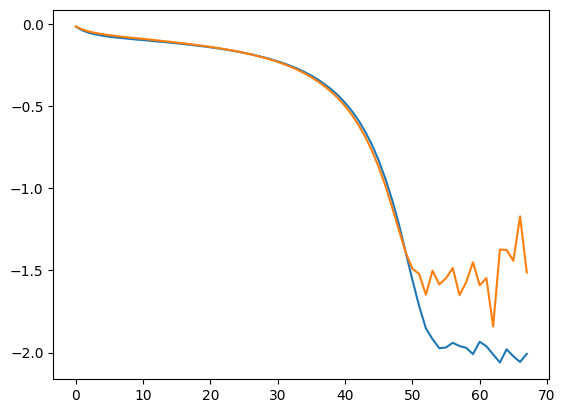

In [16]:
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.show()

### e)

In [17]:
t_x_pred = model.predict(x)[:,0]

625/625 [==============================] - 1s 2ms/step


In [18]:
t_x_opt = T_opt(x, mu1, mu2, Sigma1, Sigma2)

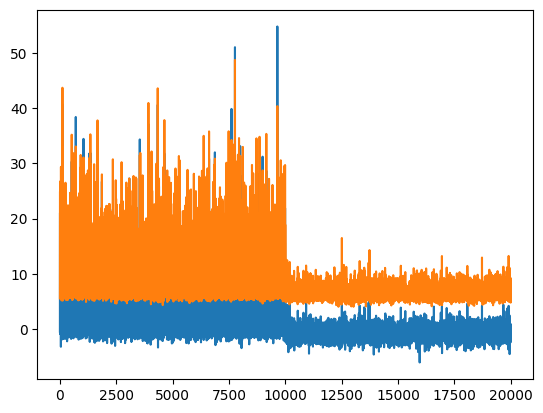

In [19]:
plt.plot(t_x_opt)
plt.plot(t_x_pred)

plt.show()

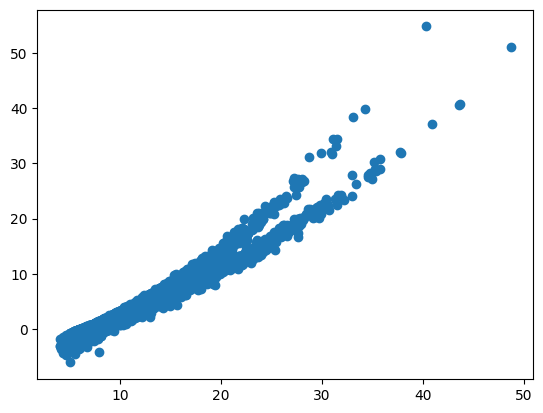

In [20]:
plt.plot(t_x_pred, t_x_opt, "o")
plt.show()

In [21]:
DV_fun(y, t_x_pred)

1.4060234266368141

In [22]:
DV_fun(y, t_x_opt)

1.8011401139807965

In [23]:
# new data
n_new = 10000
x1 = np.random.multivariate_normal(mu1, Sigma1, size=n_new)
x2 = np.random.multivariate_normal(mu2, Sigma2, size=n_new)
x_new = np.concatenate((x1, x2), axis=0)
y_new = np.concatenate((1.0*np.ones(n_new), 0.0*np.zeros(n_new)))

In [24]:
t_x_pred = model.predict(x_new)
t_x_pred = t_x_pred[:,0]

625/625 [==============================] - 1s 2ms/step


In [25]:
t_x_opt = T_opt(x_new, mu1, mu2, Sigma1, Sigma2)

In [26]:
DV_fun(y_new, t_x_pred)

2.3402461977142206

In [27]:
DV_fun(y_new, t_x_opt)

2.4079491137150435

#### HOMEWORK - just f)

### f)

In [61]:
def NWJ_loss(y_true, T_x):
    n1 = tf.math.reduce_sum(y_true)
    n2 = tf.math.reduce_sum(tf.subtract(tf.convert_to_tensor(1.0), y_true))
    first_term = tf.math.reduce_sum(tf.math.multiply(T_x, y_true))/n1
    second_term = tf.math.reduce_sum(tf.math.multiply(tf.math.exp(T_x), tf.subtract(tf.convert_to_tensor(1.0), y_true)))/n2
    return -(first_term - second_term)

In [62]:
def NWJ_fun(y, t):
    return np.mean(t[y == 1]) - np.mean(np.exp(t[y == 0] - 1))

In [63]:
model_inputs = keras.Input(shape=(5))
layer_out = Dense(64, activation='softplus')(model_inputs)
#layer_out = Dense(125, activation='tanh')(layer_out)
layer_out = Dense(64)(layer_out)
model_outputs = Dense(1)(layer_out)
model = keras.Model(model_inputs, model_outputs)

optimizer = keras.optimizers.SGD(learning_rate=1e-2)
es = tf.keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5)
model.compile(optimizer=optimizer, loss=NWJ_loss)

In [64]:
hist = model.fit(x_train, y_train, epochs=100, batch_size=1024, validation_data=(x_test, y_test), callbacks=[es])

Epoch 1/100
15/15 [==============================] - 1s 18ms/step - loss: 0.9623 - val_loss: 0.9511
Epoch 2/100
15/15 [==============================] - 0s 8ms/step - loss: 0.9466 - val_loss: 0.9409
Epoch 3/100
15/15 [==============================] - 0s 8ms/step - loss: 0.9375 - val_loss: 0.9337
Epoch 4/100
15/15 [==============================] - 0s 8ms/step - loss: 0.9308 - val_loss: 0.9282
Epoch 5/100
15/15 [==============================] - 0s 9ms/step - loss: 0.9255 - val_loss: 0.9241
Epoch 6/100
15/15 [==============================] - 0s 7ms/step - loss: 0.9217 - val_loss: 0.9210
Epoch 7/100
15/15 [==============================] - 0s 7ms/step - loss: 0.9185 - val_loss: 0.9178
Epoch 8/100
15/15 [==============================] - 0s 7ms/step - loss: 0.9155 - val_loss: 0.9153
Epoch 9/100
15/15 [==============================] - 0s 9ms/step - loss: 0.9128 - val_loss: 0.9129
Epoch 10/100
15/15 [==============================] - 0s 7ms/step - loss: 0.9103 - val_loss: 0.9104
Epoch 11

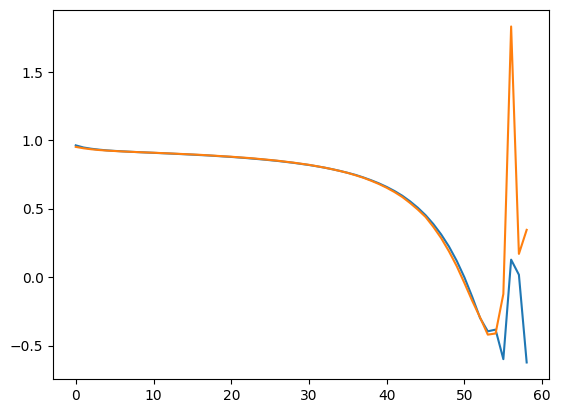

In [65]:
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.show()

In [66]:
t_x_pred = model.predict(x)[:,0]

625/625 [==============================] - 1s 2ms/step


In [67]:
t_x_opt = T_opt(x, mu1, mu2, Sigma1, Sigma2)

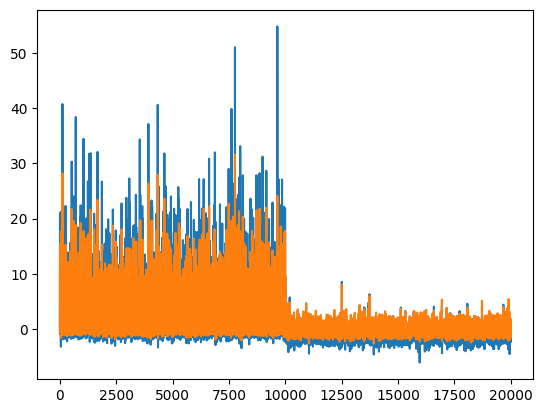

In [68]:
plt.plot(t_x_opt)
plt.plot(t_x_pred)

plt.show()

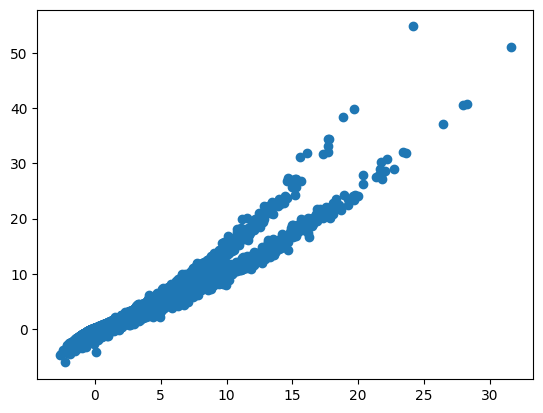

In [69]:
plt.plot(t_x_pred, t_x_opt, "o")
plt.show()

In [70]:
NWJ_fun(y, t_x_pred)

1.5872136

In [71]:
NWJ_fun(y, t_x_opt)

1.6480927732297759